In [134]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

from imblearn.over_sampling import SMOTENC

import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

In [135]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, val_corpus_df, emotion_df, val_emotion_df, valence_df, val_valence_df = get_labeled_dfs()


In [3]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [126]:
corpus_df.head()


,text
0,Test to predict breast cancer relapse is approved
1,"Two Hussein allies are hanged, Iraqi official ..."
2,Sights and sounds from CES
3,Schuey sees Ferrari unveil new car
4,Closings and cancellations top advice on flu o...


In [127]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [128]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,label
0,0,0,15,38,9,11,joy,3
1,24,26,16,13,38,5,sadness,4
2,0,0,0,17,0,4,joy,3
3,0,0,0,46,0,31,joy,3
4,1,0,23,8,11,8,fear,2


## Create Labels for Multilabel Classification

In [205]:
threshold_labels_emotion = emotion_df.iloc[:, :6]
threshold_labels_emotion['anger'] = threshold_labels_emotion['anger'].apply(lambda x: 1 if x>0 else 0)
threshold_labels_emotion['disgust'] = threshold_labels_emotion['disgust'].apply(lambda x: 1 if x>0 else 0)
threshold_labels_emotion['fear'] = threshold_labels_emotion['fear'].apply(lambda x: 1 if x>0 else 0)
threshold_labels_emotion['joy'] = threshold_labels_emotion['joy'].apply(lambda x: 1 if x>0 else 0)
threshold_labels_emotion['sadness'] = threshold_labels_emotion['sadness'].apply(lambda x: 1 if x>0 else 0)
threshold_labels_emotion['surprise'] = threshold_labels_emotion['surprise'].apply(lambda x: 1 if x>0 else 0)

In [206]:
val_threshold_labels_emotion = val_emotion_df.iloc[:, :6]
val_threshold_labels_emotion['anger'] = val_threshold_labels_emotion['anger'].apply(lambda x: 1 if x>0 else 0)
val_threshold_labels_emotion['disgust'] = val_threshold_labels_emotion['disgust'].apply(lambda x: 1 if x>0 else 0)
val_threshold_labels_emotion['fear'] = val_threshold_labels_emotion['fear'].apply(lambda x: 1 if x>0 else 0)
val_threshold_labels_emotion['joy'] = val_threshold_labels_emotion['joy'].apply(lambda x: 1 if x>0 else 0)
val_threshold_labels_emotion['sadness'] = val_threshold_labels_emotion['sadness'].apply(lambda x: 1 if x>0 else 0)
val_threshold_labels_emotion['surprise'] = val_threshold_labels_emotion['surprise'].apply(lambda x: 1 if x>0 else 0)

In [207]:
val_threshold_labels_emotion.head()

,anger,disgust,fear,joy,sadness,surprise
0,1,1,1,0,1,0
1,0,0,0,1,0,1
2,1,0,1,1,1,1
3,1,1,1,0,1,0
4,0,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

In [272]:
def evaluate_multilabel_classification(lst, df, RNN=False):
    plt.figure(figsize=(15,20))
    subplot_num = 1
    
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    
    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        accuracy_lst.append(1/accuracy)
        precision = tp/(fp + tp)
        precision_lst.append(1/precision)
        recall = tp/(tp + fn)
        recall_lst.append(1/recall)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        f1_lst.append(1/f1)
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')
        
    micro_avg_accuracy = len(lst)/sum(accuracy_lst)
    micro_avg_precision = len(lst)/sum(precision_lst)
    micro_avg_recall = len(lst)/sum(recall_lst)
    micro_avg_f1 = len(lst)/sum(f1_lst)
    print('micro_avg_accuracy:', micro_avg_accuracy)
    print('micro_avg_precision:', micro_avg_precision)
    print('micro_avg_recall:', micro_avg_recall)
    print('micro_avg_f1:', micro_avg_recall)
        

## Classifier Chain Emotion Labels

In [273]:
X_train = corpus_df['text']
y_train = threshold_labels_emotion[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']]
X_test = val_corpus_df['text']
y_test = val_threshold_labels_emotion[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)


In [274]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(1000, 2867)

In [275]:
nb_classifier = ClassifierChain(GaussianNB())
lr_classifier = ClassifierChain(LogisticRegression(class_weight='balanced'))

nb_classifier.fit(tf_idf_X_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_X_train)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

lr_classifier.fit(tf_idf_X_train, y_train)
lr_train_preds = lr_classifier.predict(tf_idf_X_train)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [276]:
# accuracy across labels
accuracy_score(y_test, lr_test_preds)

0.216

In [277]:
CC_preds_df = pd.DataFrame(lr_test_preds.toarray(), columns=['pred_anger', 'pred_disgust', 'pred_fear', 'pred_joy', 'pred_sadness', 'pred_surprise'])
# y_reindex = y_test.reset_index(drop=True)
CC_preds_df = pd.concat([CC_preds_df, y_reindex], axis=1)

anger accuracy: 0.42473118279569894
anger precision: 0.5984848484848485
anger recall 0.5524475524475524
anger f1 0.5745454545454546


disgust accuracy: 0.05128205128205128
disgust precision: 0.09090909090909091
disgust recall 0.42857142857142855
disgust f1 0.15000000000000002


fear accuracy: 0.5783132530120482
fear precision: 0.7164179104477612
fear recall 0.5333333333333333
fear f1 0.6114649681528662


joy accuracy: 0.45625
joy precision: 0.6186440677966102
joy recall 0.44785276073619634
joy f1 0.5195729537366549


sadness accuracy: 0.6134969325153374
sadness precision: 0.746268656716418
sadness recall 0.5347593582887701
sadness f1 0.6230529595015577


surprise accuracy: 0.9551569506726457
surprise precision: 0.9594594594594594
surprise recall 0.8875
surprise f1 0.922077922077922


micro_avg_accuracy: 0.2108790667069868
micro_avg_precision: 0.33212639916253556
micro_avg_recall: 0.533423555819704
micro_avg_f1: 0.533423555819704


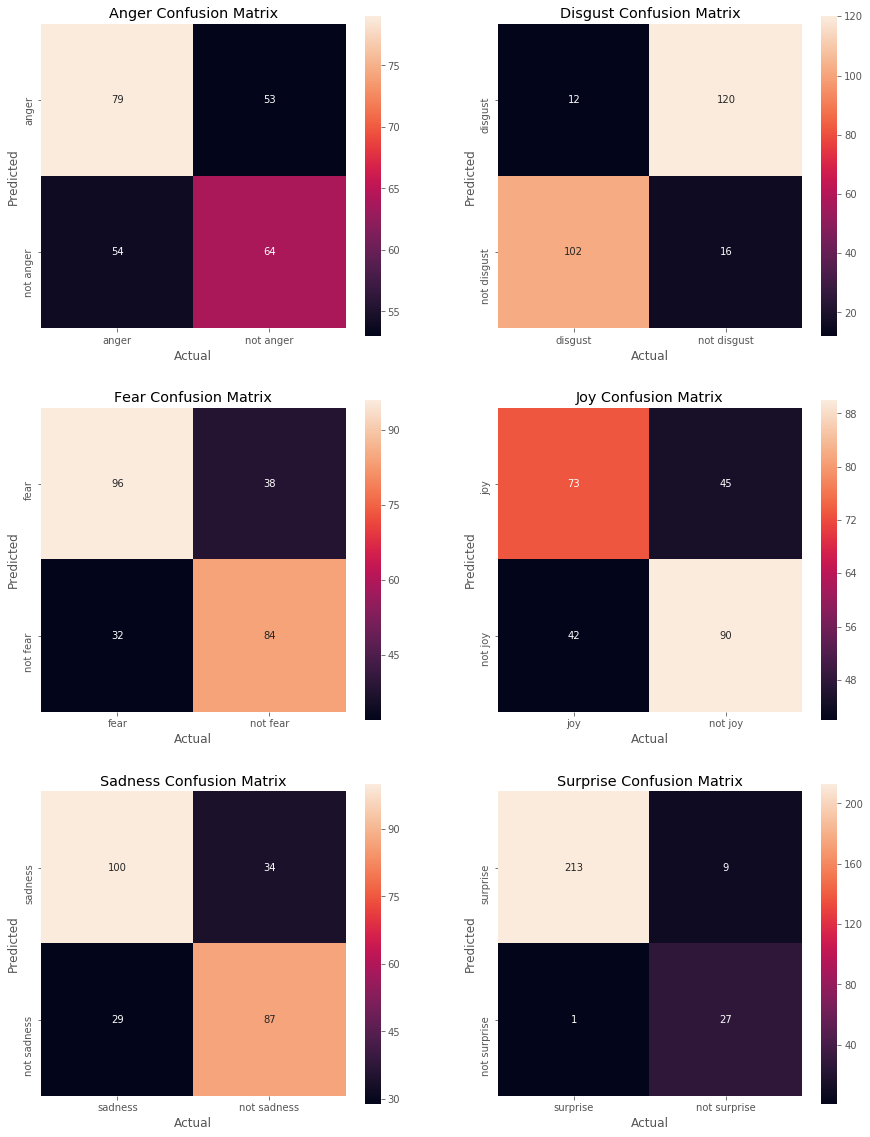

In [278]:
evaluate_multilabel_classification(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], CC_preds_df)

## Label Power Emotion Labels

In [279]:
nb_classifier = LabelPowerset(MultinomialNB(fit_prior=True))
lr_classifier = LabelPowerset(LogisticRegression(C=1e10, class_weight='balanced'))

nb_classifier.fit(tf_idf_X_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_X_train)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

lr_classifier.fit(tf_idf_X_train, y_train)
lr_train_preds = lr_classifier.predict(tf_idf_X_train)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [280]:
LP_preds_df = pd.DataFrame(lr_test_preds.toarray(), columns=['pred_anger', 'pred_disgust', 'pred_fear', 'pred_joy', 'pred_sadness', 'pred_surprise'])
# y_reindex = y_test.reset_index(drop=True)
LP_preds_df = pd.concat([LP_preds_df, y_reindex], axis=1)


In [281]:
LP_preds_df.head()

,pred_anger,pred_disgust,pred_fear,pred_joy,pred_sadness,pred_surprise,anger,disgust,fear,joy,sadness,surprise
0,1,1,1,0,1,1,1,0,0,0,1,1
1,0,0,0,1,0,1,1,0,1,1,1,1
2,1,0,1,0,1,1,1,0,1,1,1,1
3,1,1,0,0,1,1,0,0,1,1,0,1
4,0,0,0,1,0,1,0,0,1,0,1,1


anger accuracy: 0.4397905759162304
anger precision: 0.60431654676259
anger recall 0.5874125874125874
anger f1 0.5957446808510639


disgust accuracy: 0.05531914893617021
disgust precision: 0.11818181818181818
disgust recall 0.4642857142857143
disgust f1 0.18840579710144928


fear accuracy: 0.6568627450980392
fear precision: 0.7165775401069518
fear recall 0.7444444444444445
fear f1 0.7302452316076294


joy accuracy: 0.5445026178010471
joy precision: 0.6797385620915033
joy recall 0.6380368098159509
joy f1 0.6582278481012658


sadness accuracy: 0.6971153846153846
sadness precision: 0.7754010695187166
sadness recall 0.7754010695187166
sadness f1 0.7754010695187166


surprise accuracy: 0.9590163934426229
surprise precision: 0.9590163934426229
surprise recall 0.975
surprise f1 0.9669421487603306


micro_avg_accuracy: 0.2291223965945694
micro_avg_precision: 0.3917633885114595
micro_avg_recall: 0.6606390998507522
micro_avg_f1: 0.6606390998507522


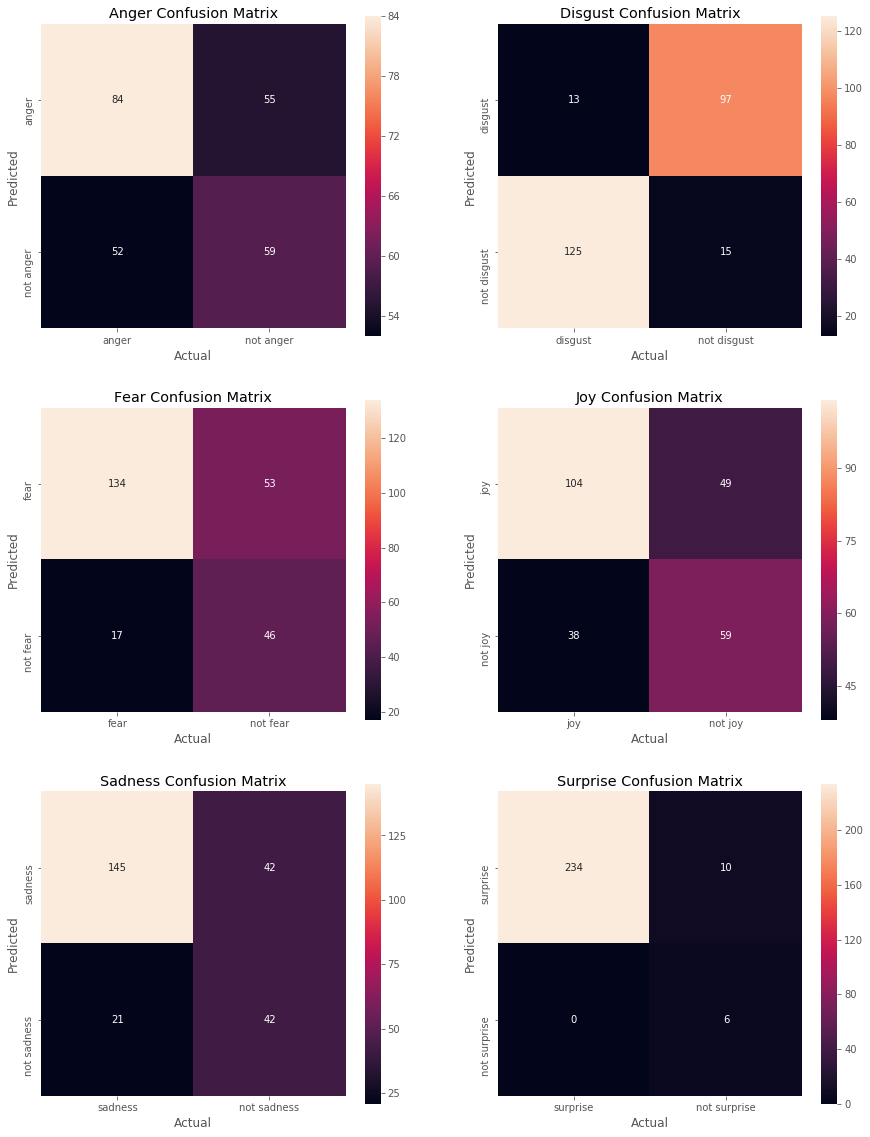

In [282]:
evaluate_multilabel_classification(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], LP_preds_df)


## RNN for Multilabel Classification

In [283]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [284]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(X)
# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=10)


In [285]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [286]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values

# USE SMOTENC to balance classes on the training set
# smt = SMOTENC(sampling_strategy='not majority', random_state=42, categorical_features=[0,1, 2,3,4,5,6,7,8,9])
# X_res, y_res = smt.fit_resample(X_train, y_train_onehot)

In [295]:
model = Sequential()

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=10, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=20,
                    batch_size=100,
                    class_weight=[{0: 3, 1: 1}, {0: 4, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 6s 8ms/step - loss: 0.7208 - acc: 0.5921 - val_loss: 0.6995 - val_acc: 0.6225
Epoch 2/20
800/800 [==============================] - 0s 353us/step - loss: 0.5240 - acc: 0.7404 - val_loss: 0.5949 - val_acc: 0.6758
Epoch 3/20
800/800 [==============================] - 0s 346us/step - loss: 0.4501 - acc: 0.7994 - val_loss: 0.5562 - val_acc: 0.7333
Epoch 4/20
800/800 [==============================] - 0s 353us/step - loss: 0.3948 - acc: 0.8383 - val_loss: 0.5244 - val_acc: 0.7683
Epoch 5/20
800/800 [==============================] - 0s 356us/step - loss: 0.3458 - acc: 0.8815 - val_loss: 0.5514 - val_acc: 0.7392
Epoch 6/20
800/800 [==============================] - 0s 350us/step - loss: 0.2986 - acc: 0.9085 - val_loss: 0.5472 - val_acc: 0.7550
Epoch 7/20
800/800 [==============================] - 0s 353us/step - loss: 0.2609 - acc: 0.9329 - val_loss: 0.5313 - val_acc: 0.7583
Epoch 8/20
800/800

200/200 [==============================] - 0s 279us/step


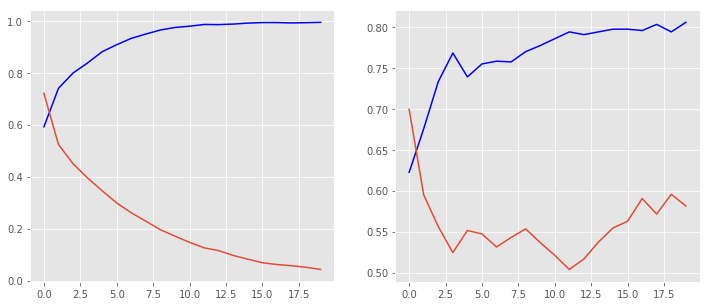

In [296]:
model.evaluate(X_test, y_test_multihot)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')


In [299]:
# model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})
RNN_preds.loc[RNN_preds['disgust']==1]

,pred_anger,pred_disgust,pred_fear,pred_joy,pred_sadness,pred_surprise,anger,disgust,fear,joy,sadness,surprise
10,0.993688,0.965866,0.999969,0.068565,0.950243,0.999349,1,1,1,1,1,1
11,0.995090,0.817496,0.995949,0.777650,0.999127,0.903420,1,1,1,0,1,1
12,0.997615,0.410938,0.999183,0.429819,0.996936,0.998743,1,1,1,0,1,1
19,0.820583,0.316921,0.265789,0.418989,0.987139,0.924932,1,1,0,0,1,1
20,0.994114,0.851495,0.999978,0.306844,0.993877,0.989212,1,1,1,0,1,1
36,0.996877,0.282774,0.988956,0.179363,0.985025,0.956614,1,1,1,0,1,1
50,0.990346,0.014984,0.990172,0.040522,0.985451,0.919152,1,1,1,0,1,1
67,0.970062,0.234249,0.998785,0.392765,0.999281,0.987843,1,1,1,1,1,1
68,0.007624,0.038189,0.819961,0.754780,0.983370,0.997993,1,1,0,0,1,1
74,0.997844,0.031244,0.998788,0.130567,0.994336,0.949353,1,1,1,0,1,0


anger accuracy: 0.46195652173913043
anger precision: 0.7589285714285714
anger recall 0.8415841584158416
anger f1 0.7981220657276994


disgust accuracy: 0.0374331550802139
disgust precision: 0.4666666666666667
disgust recall 0.35
disgust f1 0.4


fear accuracy: 0.6845238095238095
fear precision: 0.8214285714285714
fear recall 0.782312925170068
fear f1 0.8013937282229965


joy accuracy: 0.6
joy precision: 0.75
joy recall 0.8076923076923077
joy f1 0.7777777777777779


sadness accuracy: 0.7292817679558011
sadness precision: 0.8741721854304636
sadness recall 0.8741721854304636
sadness f1 0.8741721854304636


surprise accuracy: 0.9346733668341709
surprise precision: 0.9346733668341709
surprise recall 0.9946524064171123
surprise f1 0.9637305699481865


micro_avg_accuracy: 0.1741774275325669
micro_avg_precision: 0.7294778986028775
micro_avg_recall: 0.6887803424504826
micro_avg_f1: 0.6887803424504826


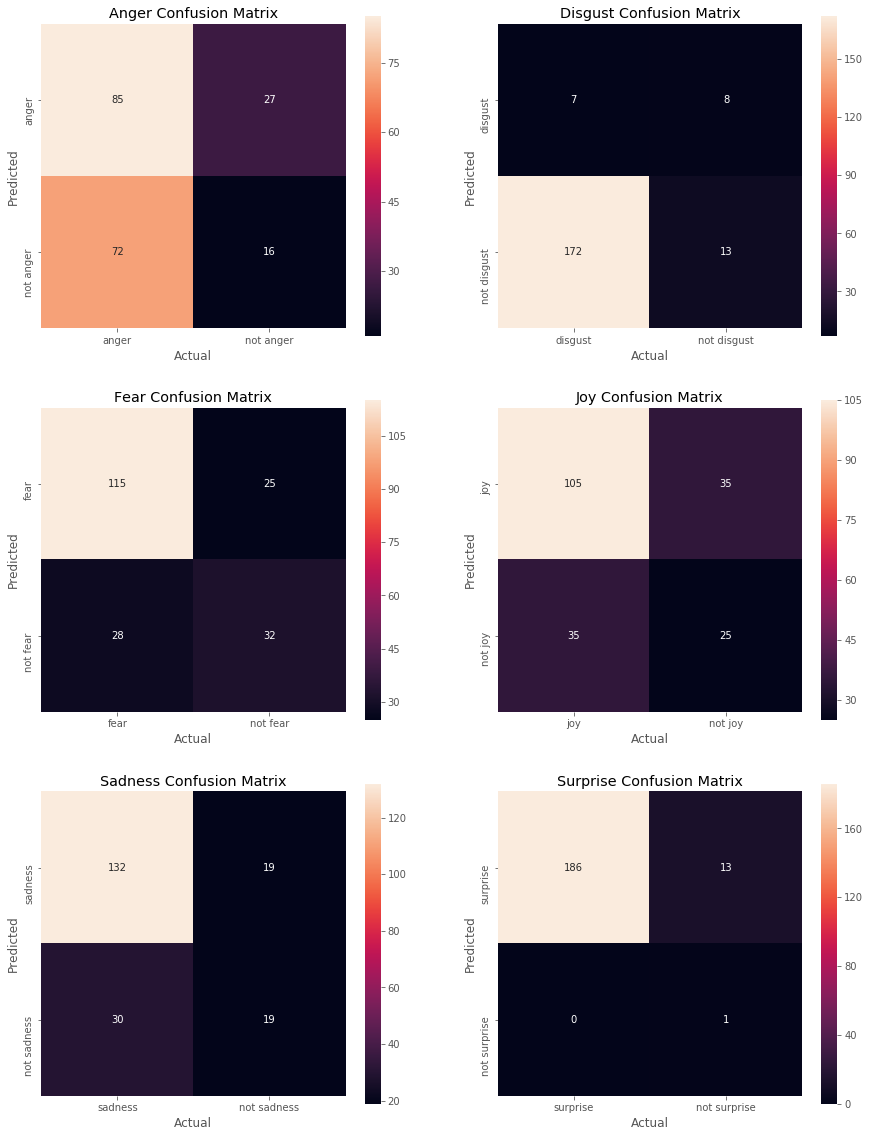

In [298]:
evaluate_multilabel_classification(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds, RNN=True)